[Eitz et al](http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/) asked non-expert humans to sketch objects of a given category and gather 20,000 unique sketches evenly distributed over 250 object categories.

    @article{eitz2012hdhso,
        author={Eitz, Mathias and Hays, James and Alexa, Marc},
        title={How Do Humans Sketch Objects?},
        journal={ACM Trans. Graph. (Proc. SIGGRAPH)},
        year={2012},
        volume={31},
        number={4},
        pages = {44:1--44:10}
    }

Download png images (525MB):

In [ ]:
%%bash
cd ~/Downloads
wget http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
unzip sketches_png.zip

In [2]:
files = !find ~/Downloads/png -name "*.png"
len(files)

20000

In [3]:
#Import libraries for doing image analysis
from skimage.io import imread
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier as RF
import glob
import os
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from matplotlib import colors
from pylab import cm
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.feature import peak_local_max
# make graphics inline
%matplotlib inline

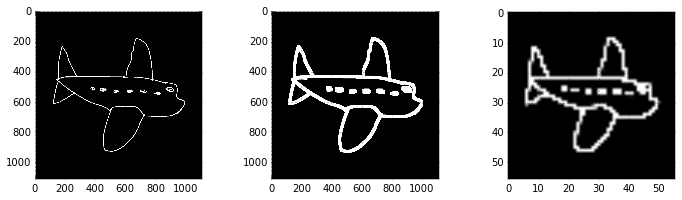

In [52]:
plt.figure(figsize=(12,3))
image = imread(files[0], as_grey=True)
imagethr = np.where(image > np.mean(image),0.,1.0)

plt.subplot(1,3,1)
plt.imshow(imagethr, cmap=cm.gray);
imdilated = morphology.dilation(imagethr, np.ones((16,16)))
plt.subplot(1,3,2)
plt.imshow(imdilated, cmap=cm.gray);

im1 = resize(imdilated,[56,56])
plt.subplot(1,3,3)
plt.imshow(im1, cmap=cm.gray);
# plt.show()

In [7]:
def process(fname):
    image = imread(fname, as_grey=True)
    imagethr = np.where(image > np.mean(image),0.,1.)
    imdilated = morphology.dilation(imagethr, np.ones((16,16)))
    im1 = resize(imdilated,[56,56])
    return im1.ravel().astype(np.int8)

forever divided by eight is also forever :(

In [12]:
import multiprocessing as mp
NUM_PROCESSES = 8
pool = mp.Pool(NUM_PROCESSES)
results = pool.map(process, files, chunksize=100)
pool.close()
pool.join()

In [13]:
len(results)

20000

In [45]:
import sklearn.cross_validation
kf = sklearn.cross_validation.KFold(len(files), n_folds=10, shuffle=True, random_state=1)
train_index, test_index = iter(kf).next()

In [15]:
X = np.empty((len(train_index),56*56),np.int8)
for i,r in enumerate(train_index):
    X[i,:] = results[r]

In [16]:
import os
home = os.path.expanduser("~")
np.save(os.path.join(home,'Downloads','binarized_sketch_train'),X)

In [17]:
X1 = np.empty((len(test_index),56*56),np.int8)
for i,r in enumerate(test_index):
    X1[i,:] = results[r]

In [18]:
np.save(os.path.join(home,'Downloads','binarized_sketch_test'),X1)

In [19]:
!(cd ~/Downloads ; tar cvfz binarized_sketch.tgz binarized_sketch_train.npy binarized_sketch_test.npy )

a binarized_sketch_train.npy
a binarized_sketch_test.npy


In [20]:
!ls -l ~/Downloads/binarized_sketch.tgz

-rw-r--r--  1 udi  staff  2975176 Mar 22 18:20 /Users/udi/Downloads/binarized_sketch.tgz


In [21]:
!aws s3 cp ~/Downloads/binarized_sketch.tgz s3://udidraw/ --grants read=uri=http://acs.amazonaws.com/groups/global/AllUsers

upload: ../../../../../Downloads/binarized_sketch.tgz to s3://udidraw/binarized_sketch.tgz


In [23]:
X.shape,X1.shape

((18000, 3136), (2000, 3136))

In [25]:
X.mean(),X.std()

(0.086656143707482994, 0.28133051108123897)

In [26]:
X1.mean(),X1.std()

(0.087477040816326526, 0.28253284436742077)

In [30]:
train_labels = ['/'.join(files[r].split('/')[-2:]) for r in train_index]
test_labels = ['/'.join(files[r].split('/')[-2:]) for r in test_index]

In [50]:
import cPickle as pickle
with open(os.path.join(home,'Downloads','binarized_sketch_labels.pkl'),'wb') as fp:
          pickle.dump((train_labels,test_labels),fp,-1)

In [51]:
!aws s3 cp ~/Downloads/binarized_sketch_labels.pkl s3://udidraw/ --grants read=uri=http://acs.amazonaws.com/groups/global/AllUsers

upload: ../../../../../Downloads/binarized_sketch_labels.pkl to s3://udidraw/binarized_sketch_labels.pkl
